### Data load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../../../Novartis/data/Boronic_reagents_mordred.csv")

C:\Users\AndrzejZuranski\Software\Miniconda3\envs\autoqchem\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# split info columns from descriptor columns
info = data[data.columns[0:7]]
df = data[data.columns[7:]]

print (df.shape)

(14489, 997)


In [4]:
# if you run a test and only want a sample of molecules studied uncomment
# the line below

# df=df.sample(1000)

### Preprocessing

In [5]:
from sklearn.preprocessing import scale
from scipy.linalg import qr # qr decomposition

In [6]:
# standardize
df=pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [7]:
# preprocessing

# zero-variance columns
zero_std_cols = df.columns[df.std() == 0]
df=df[df.columns.difference(zero_std_cols)]

print (df.shape)

(14489, 869)


In [8]:
# preprocessing continued

# drop linearly dependent columns (use qr decomposition in a rank revealing way)
tol=1e-8 # numeric tolerance for 0
Q, R, P = qr(df, pivoting=True) # pivoting qr decomposition (may take long), sorted diagonal values in R
rank=sum(np.abs(np.diag(R)) > tol) # calculate the rank of the matrix using the R part
col_idx_to_keep = P[:rank] # fetch the top features from the P pivot vector
df=df[df.columns[col_idx_to_keep]]

print (df.shape)

(14489, 762)


In [9]:
# preprocessing continued

# drop highly correlated columns
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)

print (df.shape)

(14489, 440)


### Dimensionality reduction

In [10]:
from sklearn.decomposition import PCA
from umap import UMAP

In [11]:
# first create embeddings for visualization, these have 2 dimensions only

dfs={}
dfs['all'] = df

# First 2 principal components
dfs['pc2'] = pd.DataFrame(PCA(n_components=2).fit_transform(df),
                      index=df.index,
                      columns=["PC1", "PC2"])

# 2-dim umap embedding
nneigh = np.int(np.sqrt(df.shape[1]))
dfs['umap2'] = pd.DataFrame(UMAP(n_components=2,
                             n_neighbors=nneigh).fit_transform(df),
                        index=df.index,
                        columns=["UMAP1", "UMAP2"])

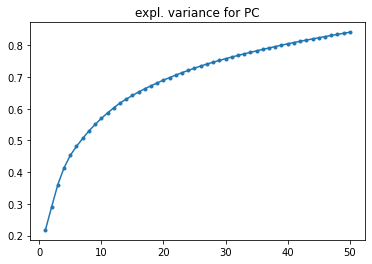

In [12]:
# explained variance plot for PCA

pc=PCA()
pc.fit(df)
expl_var=pc.explained_variance_ratio_.cumsum()
pd.Series(expl_var, index=range(1, df.shape[1]+1)).loc[:50].plot(style=".-",
                                                                title="expl. variance for PC")

Text(0.5, 1.0, 'UMAP projection')

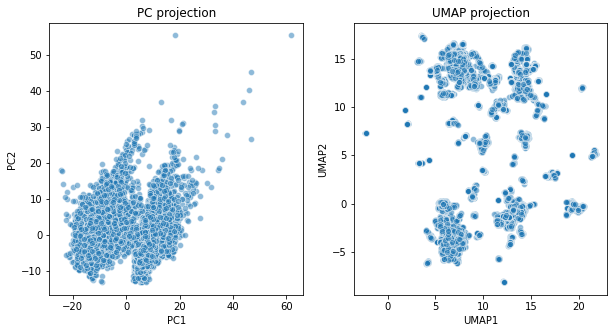

In [13]:
# Let's visualize the visualization embeddings

f, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot('PC1', 'PC2', data=dfs['pc2'], alpha=0.5, ax=ax[0]).set_title("PC projection")
sns.scatterplot('UMAP1', 'UMAP2', data=dfs['umap2'], alpha=0.5, ax=ax[1]).set_title("UMAP projection")

In [14]:
# create dimensionality reductions for clusterings

# First 10 principal components (should cover quite a bit of variance, no
# matter what dataset you have)
dfs['pc10'] = pd.DataFrame(PCA(n_components=10).fit_transform(df),
                      index=df.index,
                      columns=[f"PC{i}" for i in range(1, 11)])

# 10-dim umap embedding
dfs['umap10'] = pd.DataFrame(UMAP(n_components=10,
                              n_neighbors=nneigh).fit_transform(df),
                        index=df.index,
                        columns=[f"UMAP{i}" for i in range(1, 11)])

### Clustering

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.spatial.distance import pdist, cdist, squareform

In [16]:
# Let's compare 3 parametrizations: All features, pc10, and umap10

NCLS = 20 # fix the number of clusters for further cells (change this as desired)

Z={}
# compute linkages - this is the Agglomerative Hierarchical Clustering
Z['all'] = linkage(dfs['all'], method="ward")
Z['pc10'] = linkage(dfs['pc10'], method="ward")
Z['umap10'] = linkage(dfs['umap10'], method="ward")

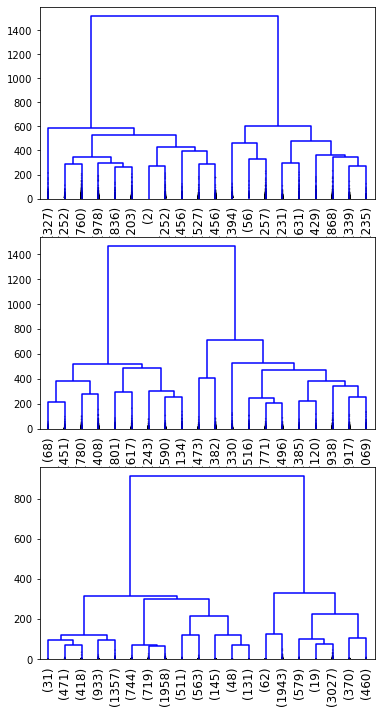

In [17]:
# plot some dendrograms (python doesn't have great plotting for dendrograms..)
f, ax = plt.subplots(3, 1, figsize=(6,12))
_=dendrogram(Z['all'], truncate_mode='lastp', p=NCLS, show_contracted=True,
          leaf_rotation=90, ax=ax[0], color_threshold=0)
_=dendrogram(Z['pc10'], truncate_mode='lastp', p=NCLS, show_contracted=True,
          leaf_rotation=90, ax=ax[1], color_threshold=0)
_=dendrogram(Z['umap10'], truncate_mode='lastp', p=NCLS, show_contracted=True,
          leaf_rotation=90, ax=ax[2], color_threshold=0)

In [18]:
# chop the dendrograms at a given height and get the cluster assignments
cls = {}
cls['all'] = fcluster(Z['all'], NCLS, criterion='maxclust')
cls['pc10'] = fcluster(Z['pc10'], NCLS, criterion='maxclust')
cls['umap10'] = fcluster(Z['umap10'], NCLS, criterion='maxclust')

Text(0.5, 1.0, '10 UMAPs - 2-UMAP projection')

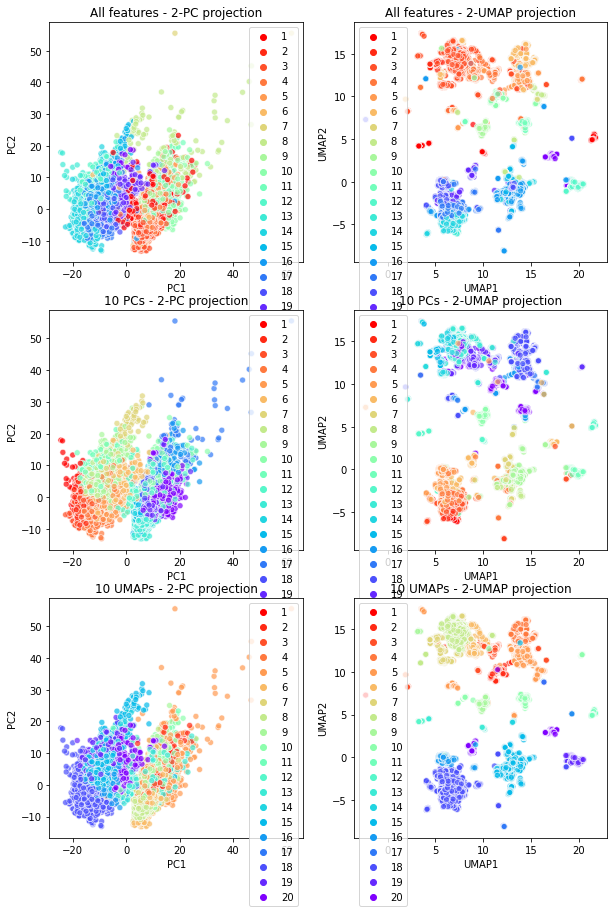

In [19]:
# clustering visualizations

f, ax = plt.subplots(3, 2, figsize=(10, 15))
color_threshold=0
sns.scatterplot("PC1", "PC2", data=dfs['pc2'], ax=ax[0][0], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['all']).set_title("All features - 2-PC projection")
sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], ax=ax[0][1], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['all']).set_title("All features - 2-UMAP projection")
sns.scatterplot("PC1", "PC2", data=dfs['pc2'], ax=ax[1][0], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['pc10']).set_title("10 PCs - 2-PC projection")
sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], ax=ax[1][1], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['pc10']).set_title("10 PCs - 2-UMAP projection")
sns.scatterplot("PC1", "PC2", data=dfs['pc2'], ax=ax[2][0], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['umap10']).set_title("10 UMAPs - 2-PC projection")
sns.scatterplot("UMAP1", "UMAP2", data=dfs['umap2'], ax=ax[2][1], alpha=0.7,
                palette='rainbow_r', legend='full', hue=cls['umap10']).set_title("10 UMAPs - 2-UMAP projection")

In [20]:
# compute consistency scores between the 3 clusterings
cls_df=pd.DataFrame(cls)

dists=pd.DataFrame(squareform(pdist(cls_df.T, metric=adjusted_rand_score)),
             columns=cls_df.columns, index=cls_df.columns)
dists.round(2)

,all,pc10,umap10
all,0.00,0.44,0.52
pc10,0.44,0.00,0.39
umap10,0.52,0.39,0.00


### Get central molecules each cluster

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw

RDKit WARNING: [13:53:13] Enabling RDKit 2019.09.3 jupyter extensions


In [22]:
# produce rdkit molecules
mols=pd.Series(info.inchi.map(Chem.MolFromInchi), index=info.index).to_frame('mol')

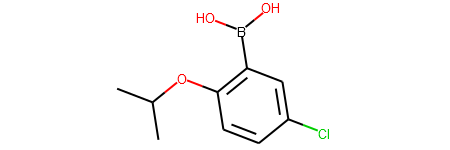

In [23]:
mols.mol[0]

In [24]:
# concat molecules and clusters
mols=pd.concat([cls_df, mols], axis=1).dropna()

Cluster 1, n molecules: 327


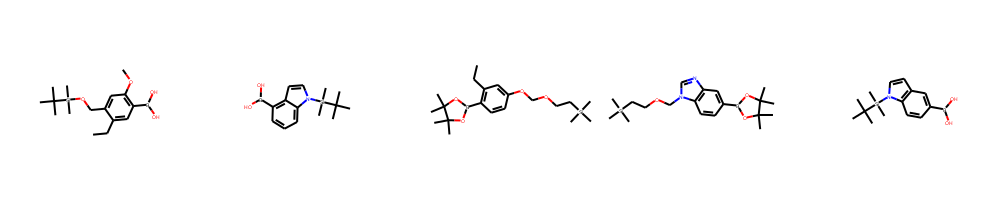

Cluster 2, n molecules: 252


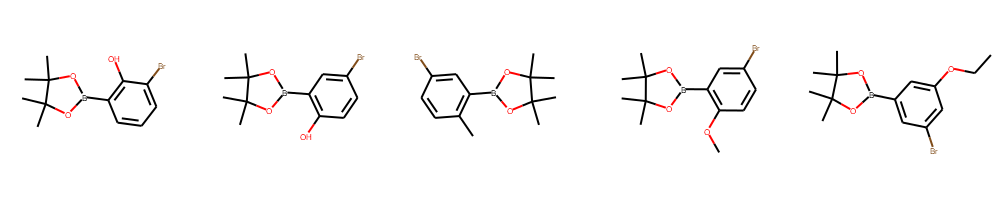

Cluster 3, n molecules: 2760


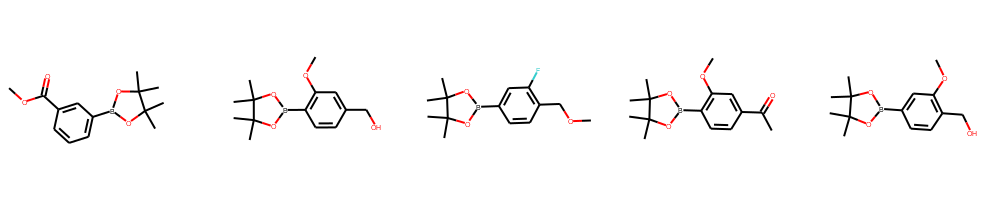

Cluster 4, n molecules: 978


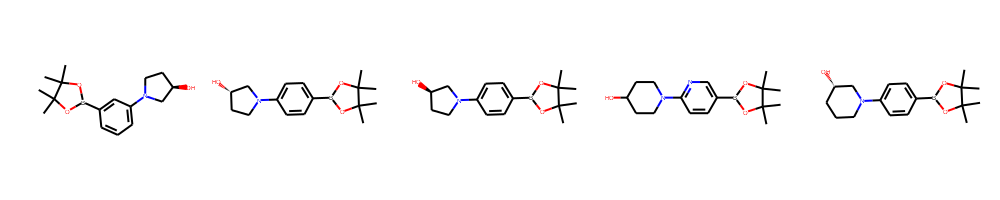

Cluster 5, n molecules: 836


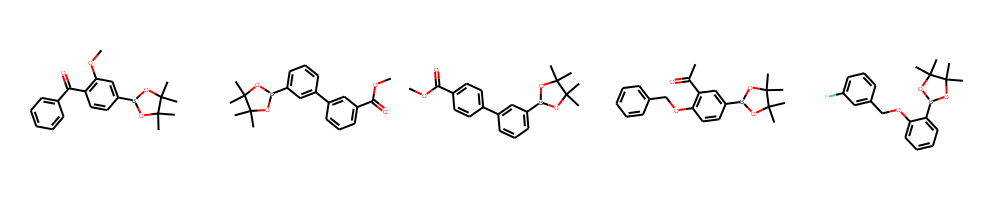

Cluster 6, n molecules: 1203


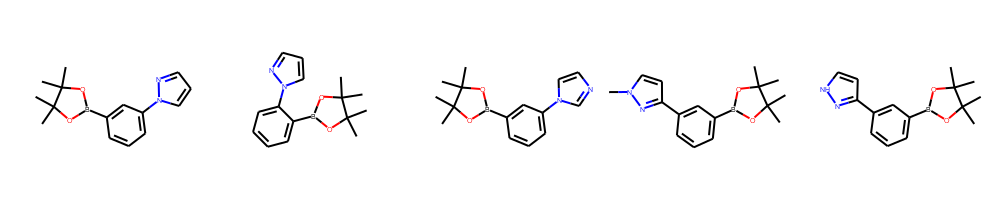

Cluster 7, n molecules: 2


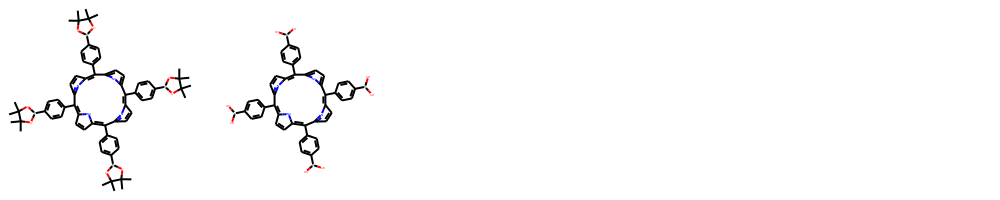

Cluster 8, n molecules: 252


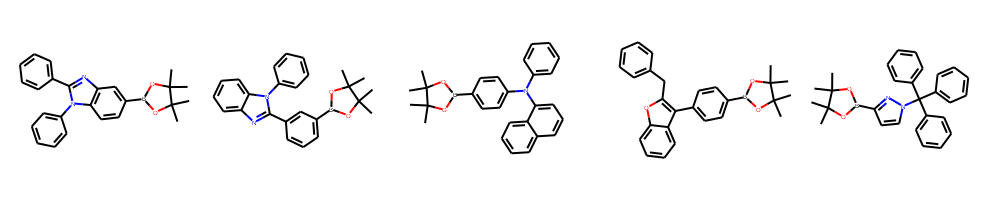

Cluster 9, n molecules: 456


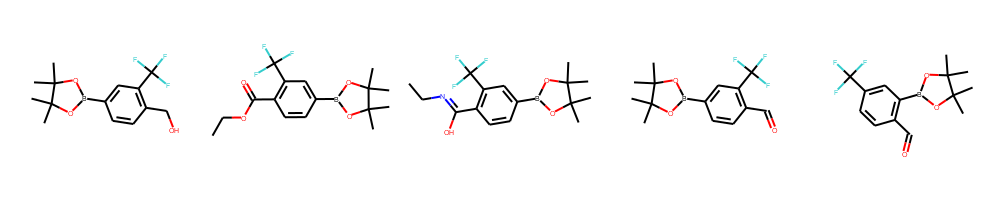

Cluster 10, n molecules: 527


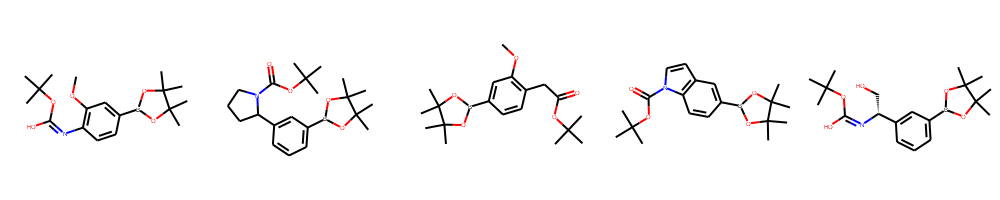

Cluster 11, n molecules: 456


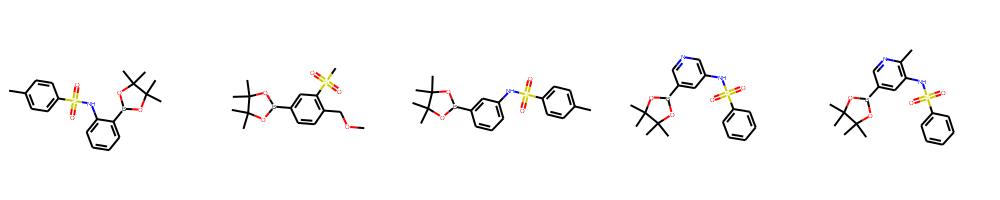

Cluster 12, n molecules: 394


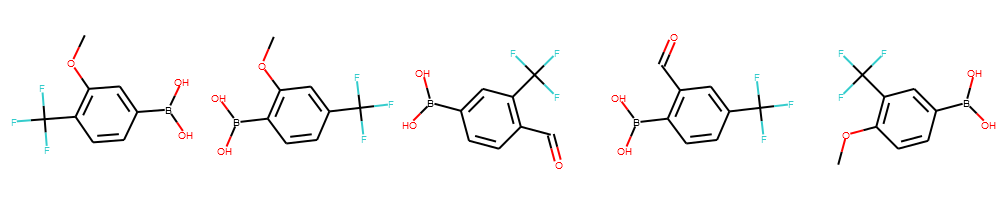

Cluster 13, n molecules: 56


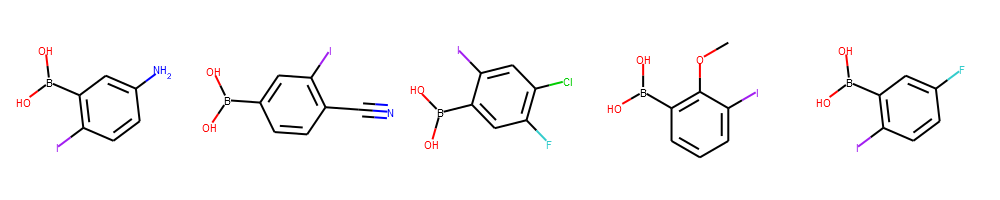

Cluster 14, n molecules: 1257


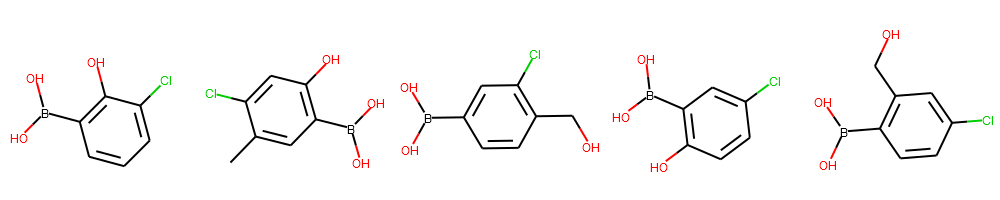

Cluster 15, n molecules: 231


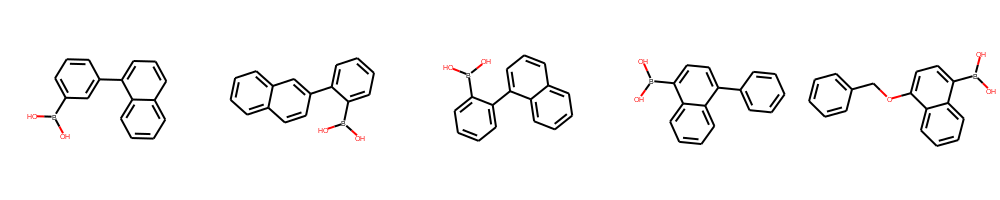

Cluster 16, n molecules: 1631


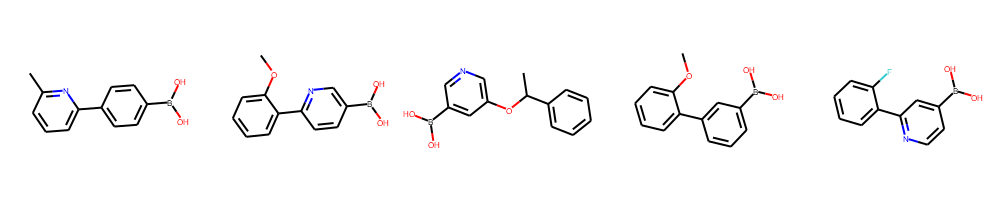

Cluster 17, n molecules: 1429


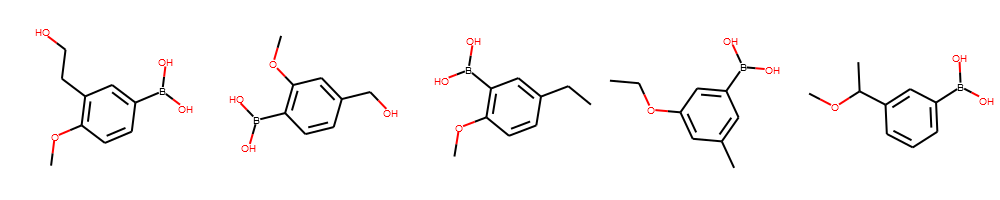

Cluster 18, n molecules: 868


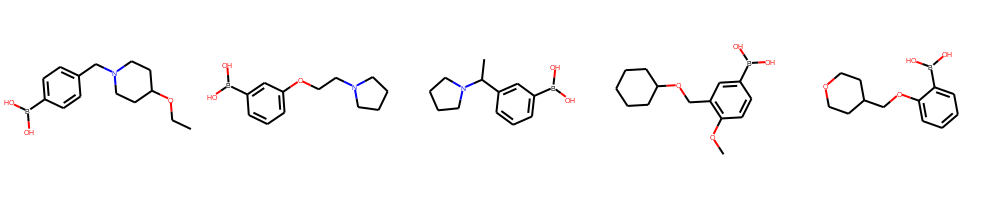

Cluster 19, n molecules: 339


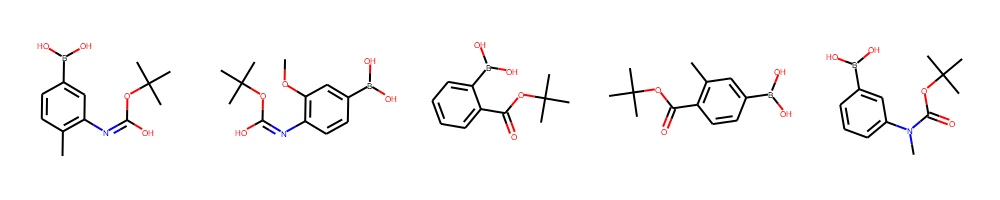

Cluster 20, n molecules: 235


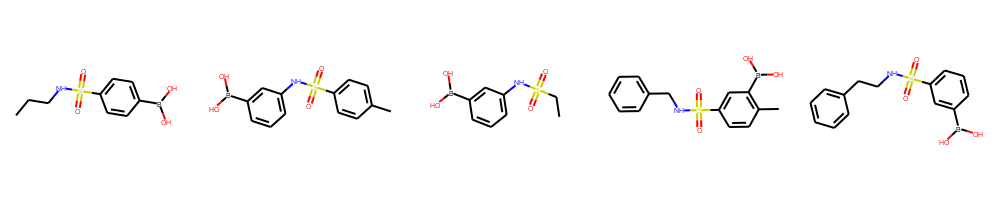

In [25]:
clustering = 'all' # change this to see what other clusterings are doing

# Loop over clusters and pick n central
n_per_cluster = 5

centers = dfs[clustering].groupby(cls_df[clustering]).mean()


for group, data in mols.groupby(clustering):
    # get descriptor data for this clsutering
    desc_data=dfs[clustering].loc[data.index]
    
    # compute distances of these molecules to their center
    dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
                    index=desc_data.index)
    # select top n central molecules
    selected=dists.sort_values().head(n_per_cluster).index
    
    print (f"Cluster {group}, n molecules: {len(data)}")
    ms = data['mol'].loc[selected]
    display(Draw.MolsToGridImage(ms, molsPerRow=5))